XGBoost to predict streamflow. Forcings are aggregated from hourly to daily to match streamflow resolution. Additional input: landcover data.
Test generalization by training and testing on different stations. RandomSearchCV to find good parameters.

In [1]:
%load_ext autoreload
%autoreload 2
import sys
sys.path.append('../..')
import os
import numpy as np
import pandas as pd
from matplotlib import pyplot as plt
from sklearn import model_selection
from sklearn import metrics
from datetime import datetime, timedelta
import hydroeval
import netCDF4 as nc
import xgboost as xgb
import scipy as sp
from src import load_data, evaluate

np.random.seed(0)

time_stamp = datetime.now().strftime('%Y%m%d-%H%M%S')
time_stamp

'20190728-093400'

In [2]:
station_data_dict = load_data.load_train_test_gridded_aggregatedForcings(include_all_forcing_vars=False)

In [3]:
landcover, landcover_legend = load_data.load_landcover_reduced()

../src/load_data.py:242: UserWarning: WARNING: valid_range not used since it
cannot be safely cast to variable data type
  landcover_fullres = np.array(landcover_nc['Band1'][:])[::-1,:]


In [4]:
station_cell_mapping = load_data.get_station_cell_mapping()

In [5]:
for station in station_data_dict.keys():
    for i in range(len(landcover_legend)):
        for row_col in station_cell_mapping[station_cell_mapping['station'] == station][['row','col']].values:
            cell_id = 39 * (row_col[1] - 1) + (row_col[0] - 1)
            station_data_dict[station]['{}_{}'.format(landcover_legend[i], cell_id)] = landcover[i,row_col[1]-1,row_col[0]-1]

In [6]:
param_dist = {
    'max_depth': sp.stats.randint(1, 8),
    'learning_rate': sp.stats.uniform(0.0005, 0.5),
    'gamma': sp.stats.uniform(0, 1),
    'min_child_weight': sp.stats.randint(1, 15),
    'subsample': sp.stats.uniform(0.7, 0.3),
    'colsample_bytree': sp.stats.uniform(0.4, 0.6),
    'colsample_bylevel': sp.stats.uniform(0.4, 0.6),
    'reg_alpha': sp.stats.expon(0, 20),
    'reg_lambda': sp.stats.expon(0, 20),
}

In [7]:
test_station_fraction = 0.25
num_test_stations = int(len(station_data_dict.keys()) * test_station_fraction)
test_stations = np.random.choice(list(station_data_dict.keys()), size=num_test_stations, replace=False)
train_stations = np.array(list(s for s in station_data_dict.keys() if s not in test_stations))
train_stations, test_stations

(array(['02GA010', '02GA018', '02GA038', '02GA047', '02GB007', '02GC002',
        '02GC007', '02GC010', '02GC018', '02GE007', '02GG002', '02GG003',
        '02GG006', '02GG009', '02GG013', '04159492', '04159900',
        '04161820', '04165500', '04166100', '04174500', '04176500',
        '04198000', '04199000', '04199500', '04200500', '04207200',
        '04208504', '04209000', '04212100', '04213000', '04213500',
        '04214500', '04215000', '04215500'], dtype='<U8'),
 array(['04166500', '04164000', '04177000', '02GB001', '02GC026',
        '04196800', '04193500', '02GD004', '04160600', '04197100',
        '04195820'], dtype='<U8'))

In [8]:
# Create test and train splits for each station (by time), then create predictions for each subbasin
history = 7
train_start = datetime.strptime('2010-01-01', '%Y-%m-%d') + timedelta(days=history + 1)
train_end = '2012-12-31'
test_start = datetime.strptime(train_end, '%Y-%m-%d') + timedelta(days=1)
test_end = '2014-12-31'

validation_fraction = 0.1

data = pd.DataFrame()
data = pd.concat([station_data_dict[station].reset_index() for station in station_data_dict.keys()], ignore_index=True)

train = data[(data['date'] >= train_start) & (data['date'] <= train_end) & (data['station'].isin(train_stations))].copy()
num_validation_samples = int(validation_fraction * train.shape[0])
shuffle_indices = np.arange(train.shape[0])
np.random.shuffle(shuffle_indices)
train = train.iloc[shuffle_indices]
val, train = train.iloc[:num_validation_samples].copy(), train.iloc[num_validation_samples:].copy()
    
test = data[(data['date'] >= test_start) & (data['date'] <= test_end) & (data['station'].isin(test_stations))].copy()
print('Shapes: train {}, val {}, test {}'.format(train.shape, val.shape, test.shape))

val = [(train.drop(['station', 'date', 'runoff'], axis=1), train['runoff']), 
       (val.drop(['station', 'date', 'runoff'], axis=1), val['runoff'])]

xgb_model = xgb.XGBRegressor(n_estimators=800, n_jobs=2, random_state=123)
m = model_selection.RandomizedSearchCV(xgb_model, param_dist, n_iter=500, cv=3, return_train_score=True, scoring='neg_mean_squared_error', n_jobs=44, random_state=123, verbose=5)
m.fit(train.drop(['station', 'date', 'runoff'], axis=1), train['runoff'], eval_set=val, eval_metric='rmse', early_stopping_rounds=100, verbose=False)

cv_results = pd.DataFrame(m.cv_results_).sort_values(by='mean_test_score', ascending=False)
print(cv_results.filter(regex='param_|mean_test_score|mean_train_score', axis=1).head())
print('Best params: {}'.format(m.best_params_))
print(cv_results.loc[m.best_index_, ['mean_train_score', 'mean_test_score']])

test = test[~pd.isna(test['runoff'])]

predict = data[(data['date'] >= test_start) & (data['date'] <= test_end)].copy()
predict['is_test_station'] = predict['station'].apply(lambda s: s in test_stations)
predict['actual'] = predict['runoff']
predict['runoff'] = np.nan
predict['runoff'] = m.predict(predict.drop(['station', 'actual', 'date', 'runoff', 'is_test_station'], axis=1))

/home/mgauch/miniconda3/envs/gwf/lib/python3.7/site-packages/ipykernel_launcher.py:11: FutureWarning: Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=False'.

To retain the current behavior and silence the warning, pass 'sort=True'.

  # This is added back by InteractiveShellApp.init_path()


Shapes: train (33309, 15624), val (3701, 15624), test (8030, 15624)
Fitting 3 folds for each of 500 candidates, totalling 1500 fits


[Parallel(n_jobs=44)]: Using backend LokyBackend with 44 concurrent workers.
[Parallel(n_jobs=44)]: Done  74 tasks      | elapsed: 19.2min
[Parallel(n_jobs=44)]: Done 200 tasks      | elapsed: 43.3min
[Parallel(n_jobs=44)]: Done 362 tasks      | elapsed: 76.9min
[Parallel(n_jobs=44)]: Done 560 tasks      | elapsed: 116.4min
[Parallel(n_jobs=44)]: Done 794 tasks      | elapsed: 167.3min
[Parallel(n_jobs=44)]: Done 1064 tasks      | elapsed: 221.2min
[Parallel(n_jobs=44)]: Done 1370 tasks      | elapsed: 288.7min
[Parallel(n_jobs=44)]: Done 1500 out of 1500 | elapsed: 311.6min finished
/home/mgauch/miniconda3/envs/gwf/lib/python3.7/site-packages/xgboost/core.py:587: FutureWarning: Series.base is deprecated and will be removed in a future version
  if getattr(data, 'base', None) is not None and \
/home/mgauch/miniconda3/envs/gwf/lib/python3.7/site-packages/xgboost/core.py:588: FutureWarning: Series.base is deprecated and will be removed in a future version
  data.base is not None and isin

    param_colsample_bylevel param_colsample_bytree param_gamma  \
38                 0.776969               0.980507    0.281418   
41                  0.90235               0.610457    0.911389   
122                0.780451               0.558638    0.690915   
443                0.949317               0.503283    0.977231   
138                0.832081               0.828863    0.164866   

    param_learning_rate param_max_depth param_min_child_weight  \
38             0.123698               6                      8   
41             0.200706               4                      5   
122            0.174073               6                      7   
443            0.111612               5                     10   
138            0.168496               7                     10   

    param_reg_alpha param_reg_lambda param_subsample  mean_test_score  \
38          44.5265         0.703116        0.847443      -212.362983   
41          10.2921          2.19611        0.839778      -2

02GA010 	NSE: 0.36037011334753966 	MSE: 304.9586106381589 (clipped to 0)
02GA018 	NSE: 0.4192810981300764 	MSE: 145.84939918228213 (clipped to 0)
02GA038 	NSE: 0.33191975205944635 	MSE: 109.92489310085115 (clipped to 0)
02GA047 	NSE: 0.23408898473409057 	MSE: 60.0397833776269 (clipped to 0)
02GB001 	NSE: -0.5059469013391871 	MSE: 11309.47328477944 (clipped to 0)
02GB007 	NSE: 0.3906168684295881 	MSE: 19.056638144028167 (clipped to 0)
02GC002 	NSE: 0.578222609377137 	MSE: 54.19967462935107 (clipped to 0)
02GC007 	NSE: 0.4529486489126052 	MSE: 16.47792219096717 (clipped to 0)
02GC010 	NSE: 0.4762659366631371 	MSE: 31.13594806131174 (clipped to 0)
02GC018 	NSE: 0.46548165647019357 	MSE: 36.201217870138954 (clipped to 0)
02GC026 	NSE: 0.20032720874605836 	MSE: 128.61357678973405 (clipped to 0)
02GD004 	NSE: 0.04042765961649475 	MSE: 52.83700222359252 (clipped to 0)
02GE007 	NSE: 0.3594473671039513 	MSE: 23.172028954294575 (clipped to 0)
02GG002 	NSE: 0.6311805908409801 	MSE: 88.95290754232

../src/evaluate.py:44: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
  f = plt.figure(figsize=(17,4))
../src/evaluate.py:44: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
  f = plt.figure(figsize=(17,4))
../src/evaluate.py:44: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
  f = plt.figure(figsize=(17,4))


04160600 	NSE: -0.4409771177045032 	MSE: 41.688787154472486 (clipped to 0)
04161820 	NSE: 0.41325957385734347 	MSE: 18.52811799222447 (clipped to 0)
04164000 	NSE: 0.3272692387793258 	MSE: 117.88083369957386 (clipped to 0)


../src/evaluate.py:44: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
  f = plt.figure(figsize=(17,4))
../src/evaluate.py:44: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
  f = plt.figure(figsize=(17,4))
../src/evaluate.py:44: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
  f = plt.figure(figsize=(17,4))


04165500 	NSE: 0.557474217494985 	MSE: 198.10061297150347 (clipped to 0)
04166100 	NSE: 0.4756612572199854 	MSE: 3.8451373325604306 (clipped to 0)
04166500 	NSE: 0.2295531309590838 	MSE: 26.62995082759065 (clipped to 0)


../src/evaluate.py:44: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
  f = plt.figure(figsize=(17,4))
../src/evaluate.py:44: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
  f = plt.figure(figsize=(17,4))
../src/evaluate.py:44: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
  f = plt.figure(figsize=(17,4))


04174500 	NSE: 0.32509775695430254 	MSE: 63.82836440609232 (clipped to 0)
04176500 	NSE: 0.14189404512631254 	MSE: 586.1500526904829 (clipped to 0)
04177000 	NSE: 0.08265732740768428 	MSE: 24.7222289047741 (clipped to 0)


../src/evaluate.py:44: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
  f = plt.figure(figsize=(17,4))
../src/evaluate.py:44: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
  f = plt.figure(figsize=(17,4))
../src/evaluate.py:44: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
  f = plt.figure(figsize=(17,4))


04193500 	NSE: -0.2016840925425707 	MSE: 85080.13413525483 (clipped to 0)
04195820 	NSE: -2.3427889787130196 	MSE: 3923.746767208419 (clipped to 0)
04196800 	NSE: 0.007305008138959179 	MSE: 297.0624743450815 (clipped to 0)


../src/evaluate.py:44: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
  f = plt.figure(figsize=(17,4))
../src/evaluate.py:44: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
  f = plt.figure(figsize=(17,4))
../src/evaluate.py:44: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
  f = plt.figure(figsize=(17,4))


04197100 	NSE: -2.5966213319837093 	MSE: 368.8853439852537 (clipped to 0)
04198000 	NSE: 0.5207394370992883 	MSE: 3540.565877433675 (clipped to 0)
04199000 	NSE: 0.428578422791825 	MSE: 584.3375904219063 (clipped to 0)


../src/evaluate.py:44: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
  f = plt.figure(figsize=(17,4))
../src/evaluate.py:44: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
  f = plt.figure(figsize=(17,4))
../src/evaluate.py:44: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
  f = plt.figure(figsize=(17,4))


04199500 	NSE: 0.3224029713718112 	MSE: 274.18836508015653 (clipped to 0)
04200500 	NSE: 0.5289383979205875 	MSE: 471.39367973870367 (clipped to 0)
04207200 	NSE: 0.4041096921714067 	MSE: 13.947582124742341 (clipped to 0)


../src/evaluate.py:44: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
  f = plt.figure(figsize=(17,4))
../src/evaluate.py:44: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
  f = plt.figure(figsize=(17,4))
../src/evaluate.py:44: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
  f = plt.figure(figsize=(17,4))


04208504 	NSE: 0.5258867735360594 	MSE: 462.98515191275425 (clipped to 0)
04209000 	NSE: 0.4669123250074798 	MSE: 166.67306864132246 (clipped to 0)
04212100 	NSE: 0.4900543826159882 	MSE: 748.7659176791326 (clipped to 0)


../src/evaluate.py:44: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
  f = plt.figure(figsize=(17,4))
../src/evaluate.py:44: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
  f = plt.figure(figsize=(17,4))
../src/evaluate.py:44: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
  f = plt.figure(figsize=(17,4))


04213000 	NSE: 0.44658107224817667 	MSE: 99.32167236358954 (clipped to 0)
04213500 	NSE: 0.6107226224194576 	MSE: 398.7823023545497 (clipped to 0)
04214500 	NSE: 0.5097263947239504 	MSE: 59.09615223993572 (clipped to 0)


../src/evaluate.py:44: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
  f = plt.figure(figsize=(17,4))
../src/evaluate.py:44: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
  f = plt.figure(figsize=(17,4))


04215000 	NSE: 0.4187394415276532 	MSE: 55.83171162248338 (clipped to 0)
04215500 	NSE: 0.47109089912428315 	MSE: 95.51300319791216 (clipped to 0)
Train Median NSE (clipped to 0) 0.4542359008749365 / Min 0.14189404512631254 / Max 0.6566631919282997
Train Median MSE (clipped to 0) 88.95290754232846 / Min 3.8451373325604306 / Max 3540.565877433675
Test Median NSE (clipped to 0) 0.007305008138959179 / Min -2.5966213319837093 / Max 0.3272692387793258
Test Median MSE (clipped to 0) 128.61357678973405 / Min 24.7222289047741 / Max 85080.13413525483


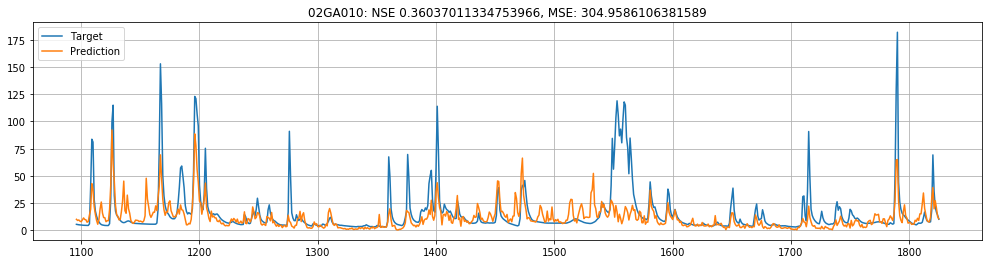

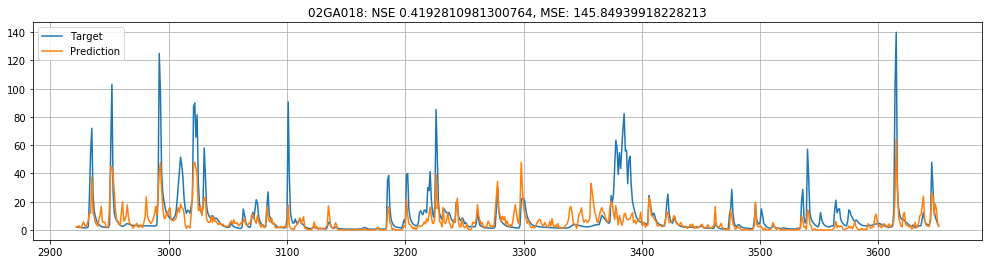

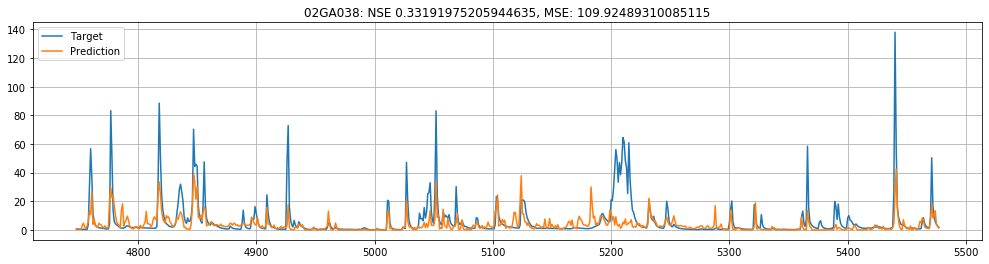

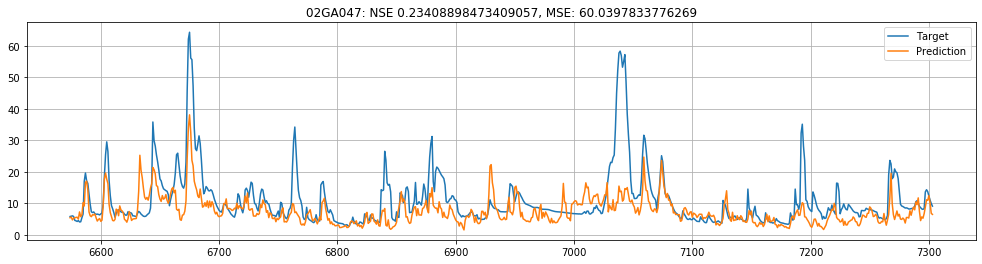

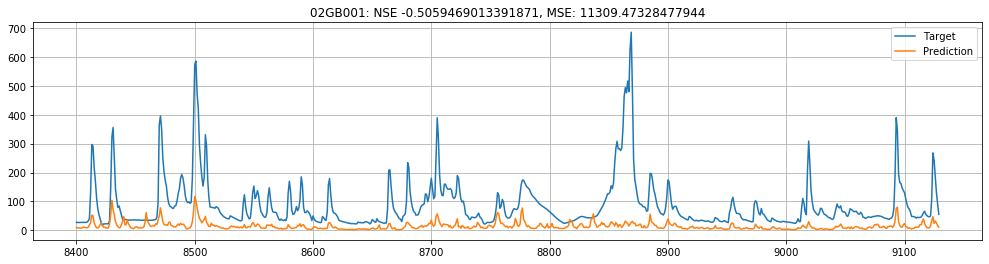

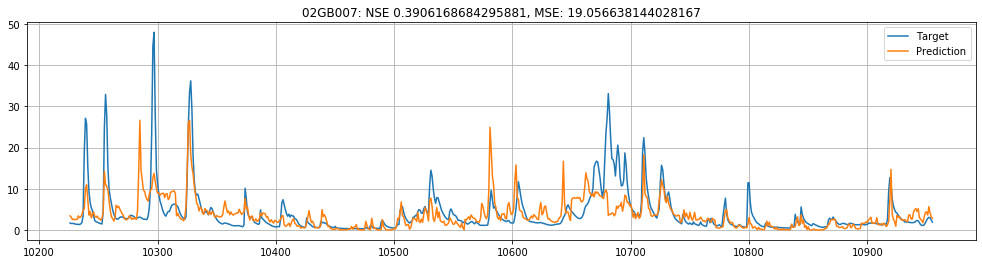

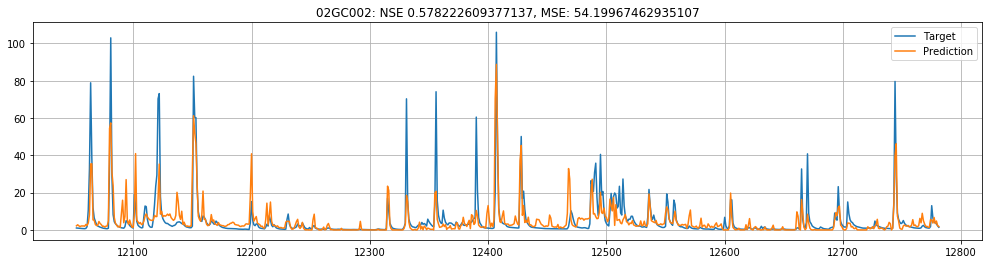

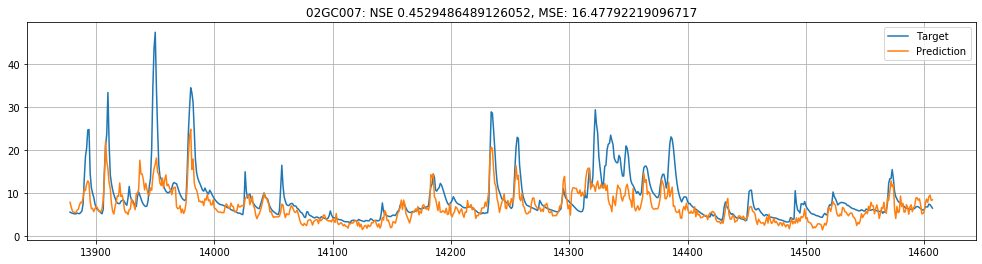

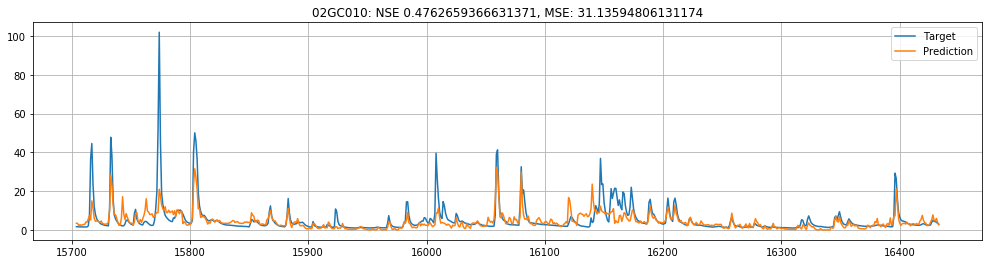

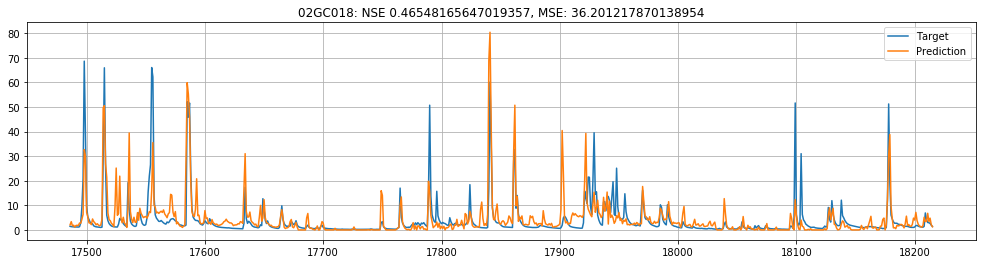

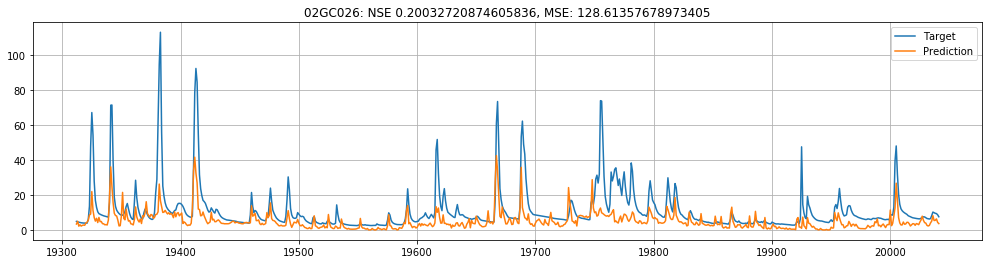

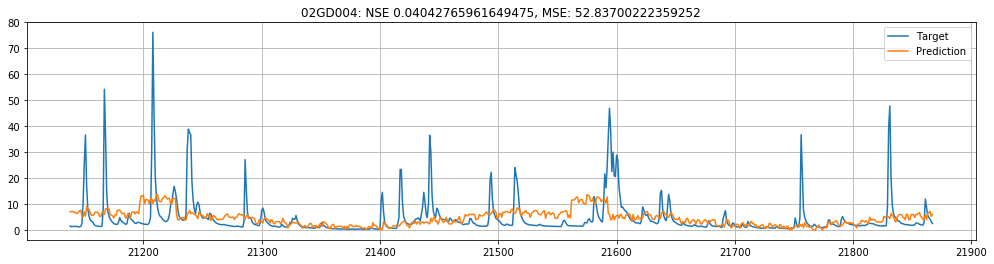

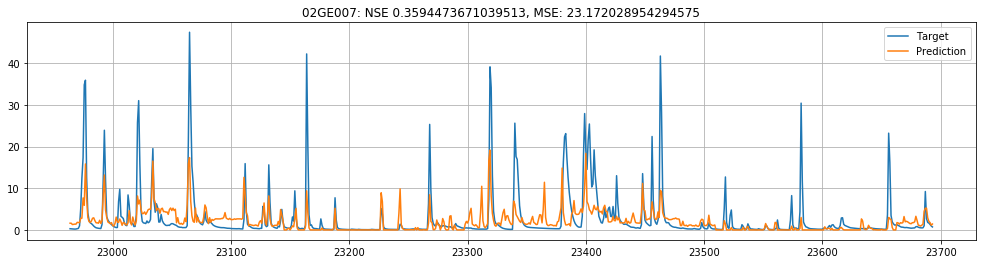

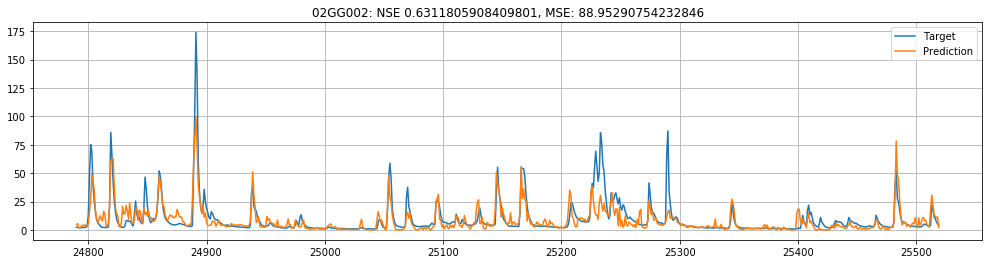

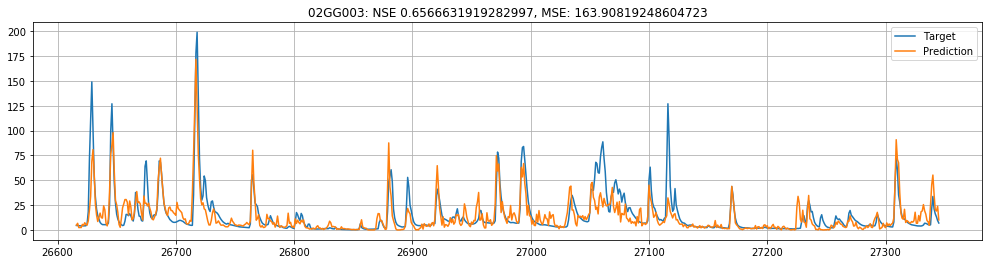

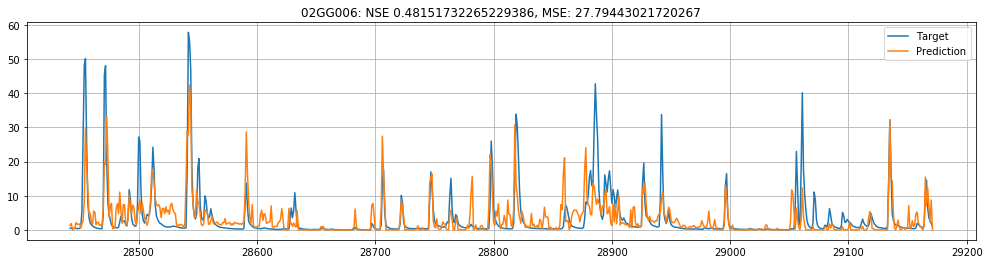

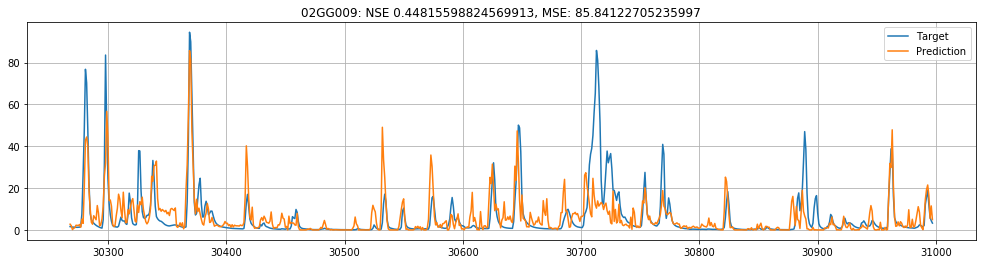

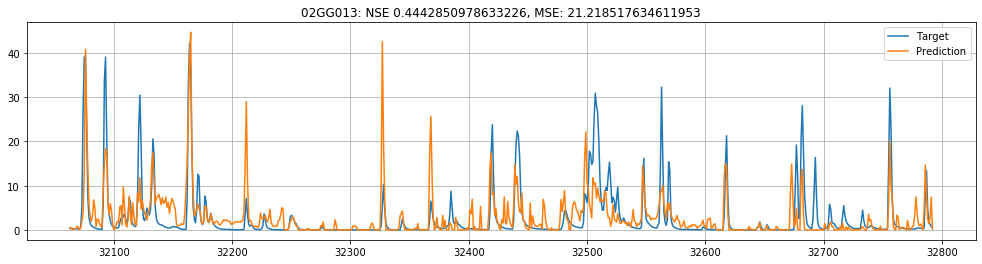

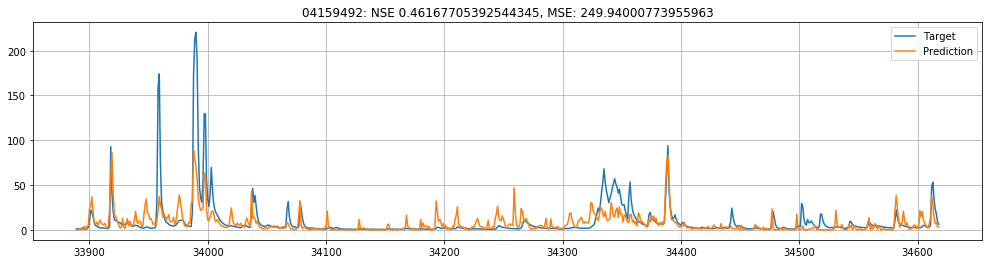

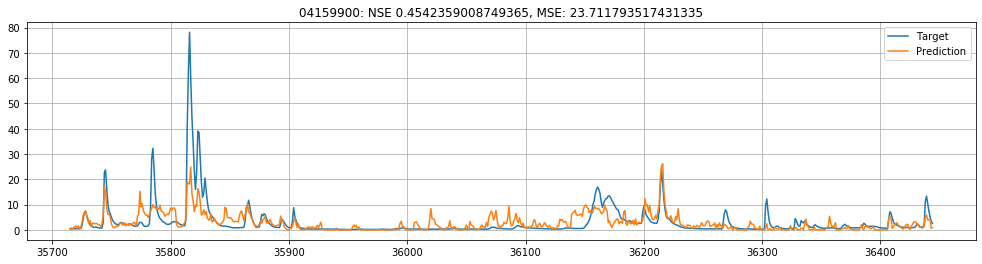

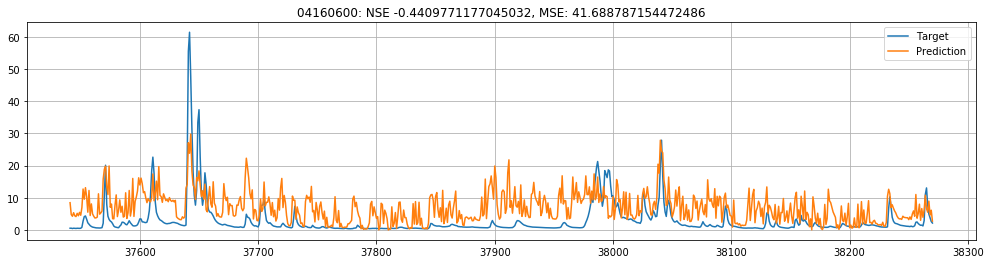

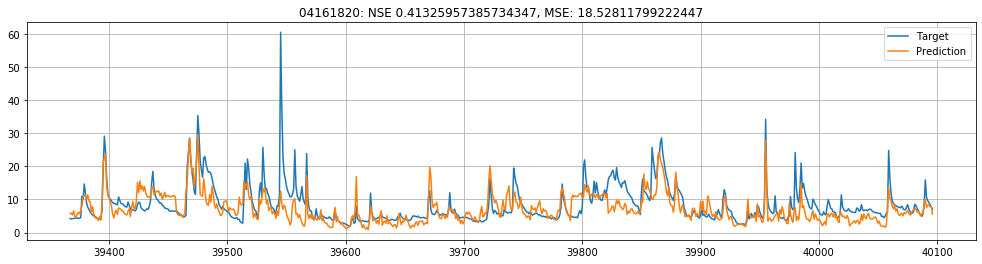

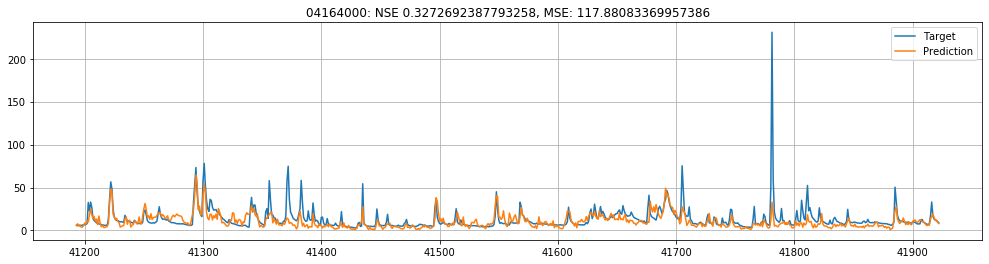

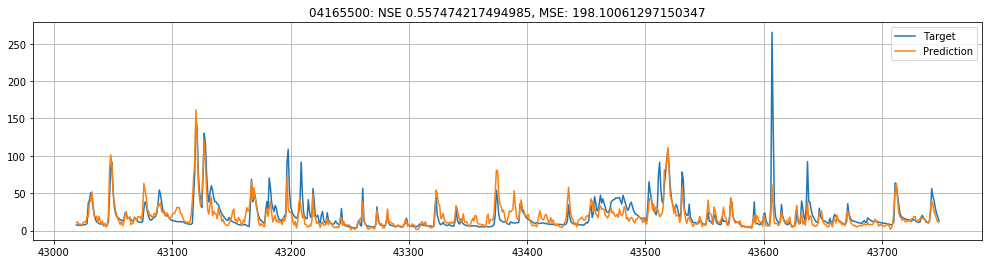

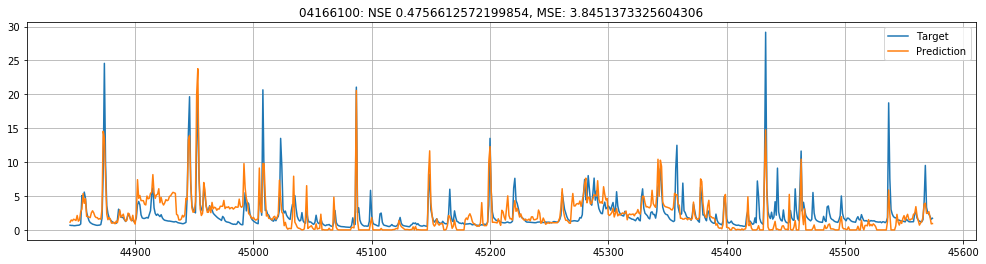

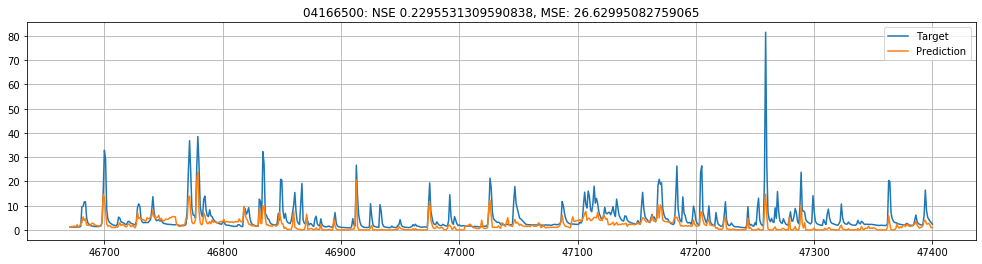

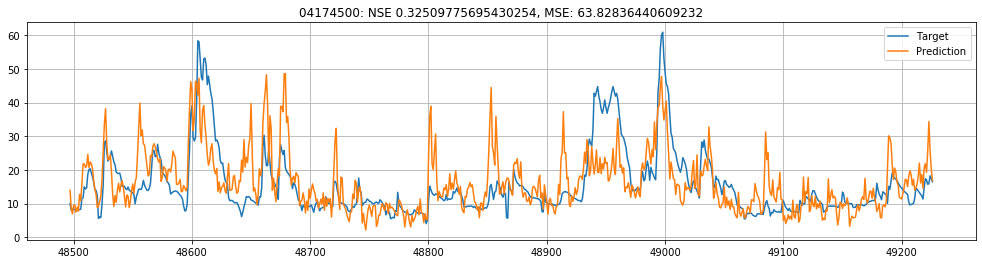

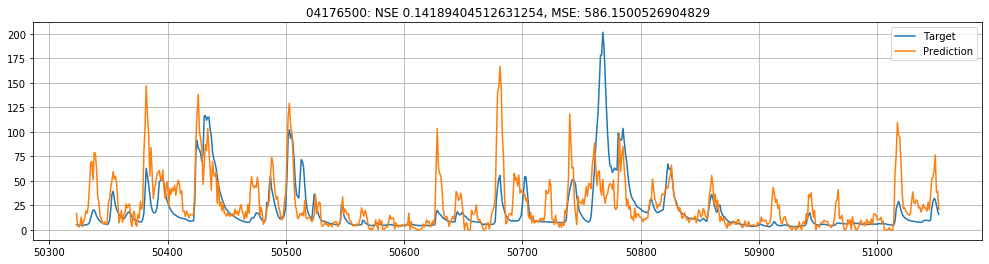

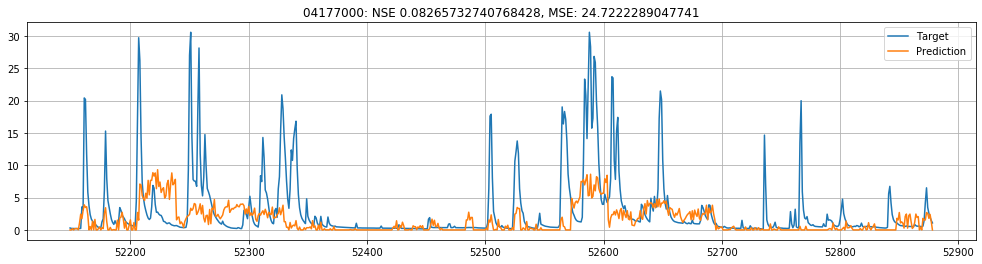

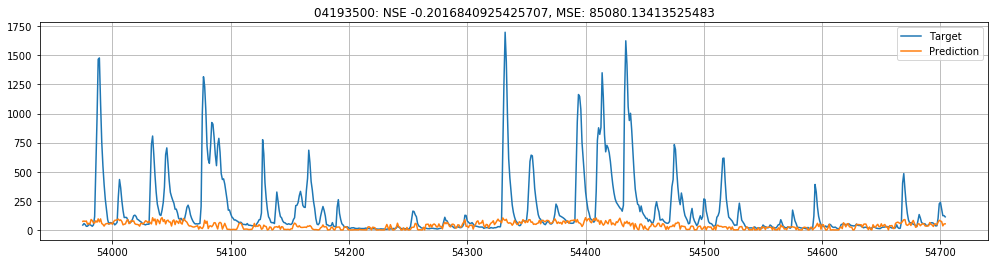

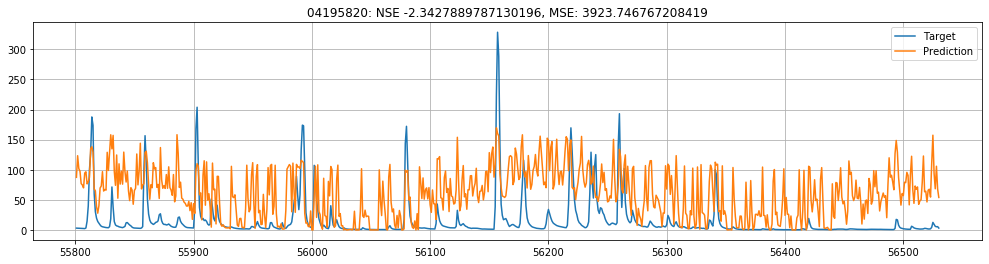

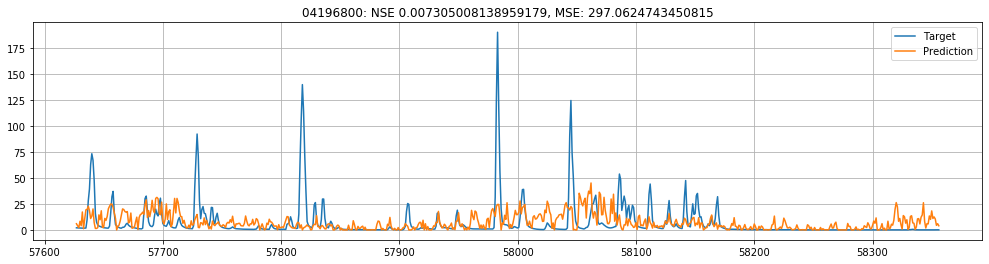

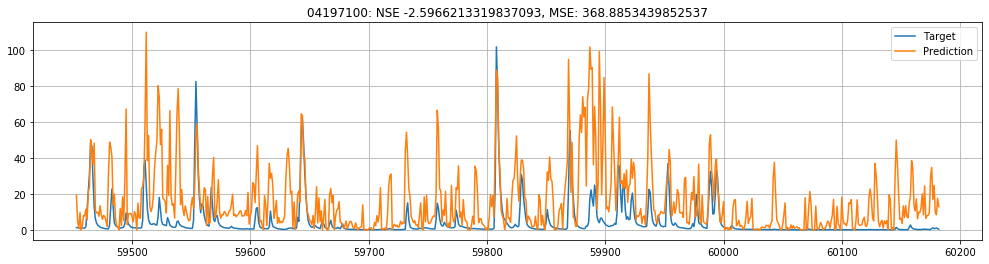

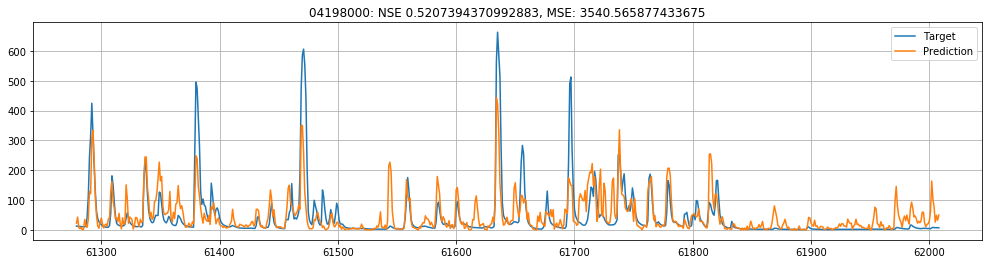

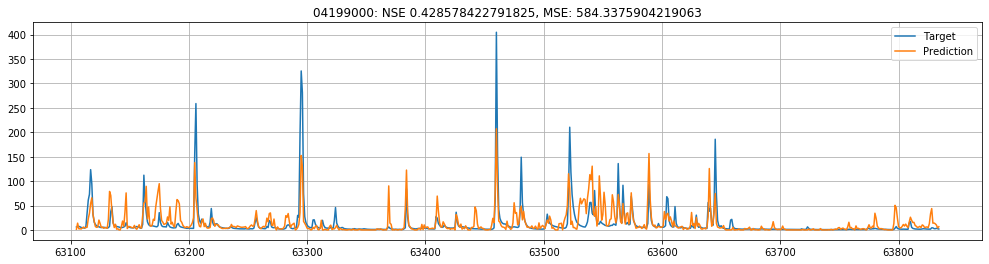

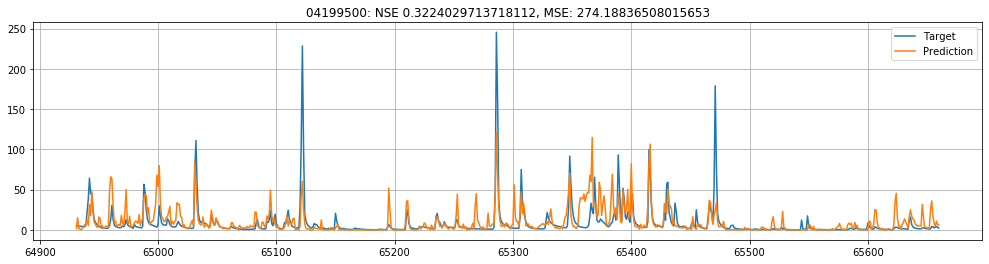

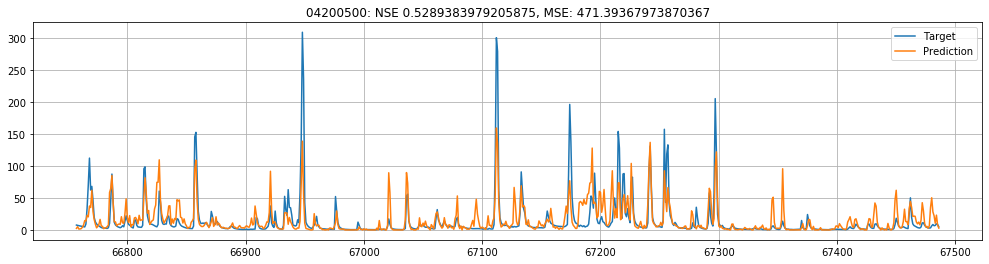

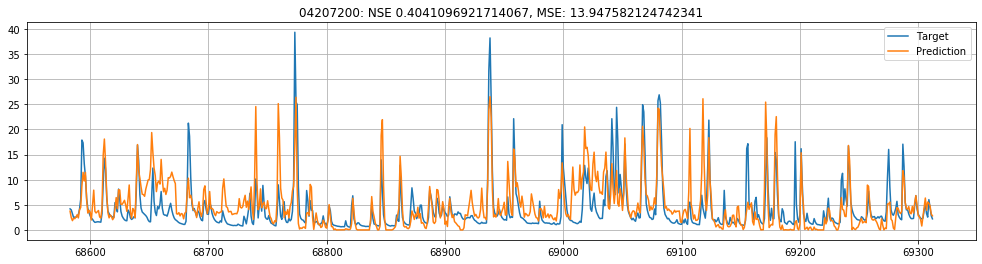

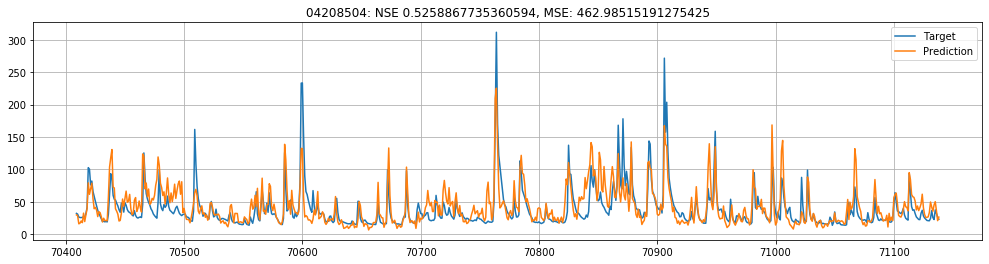

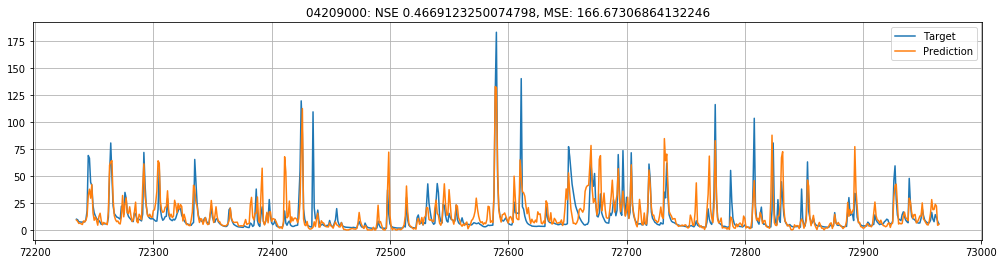

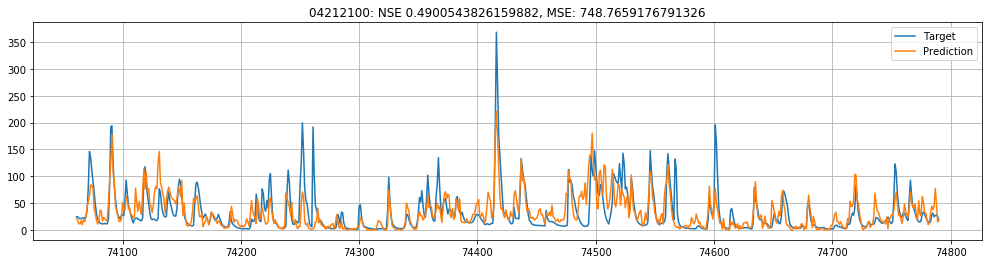

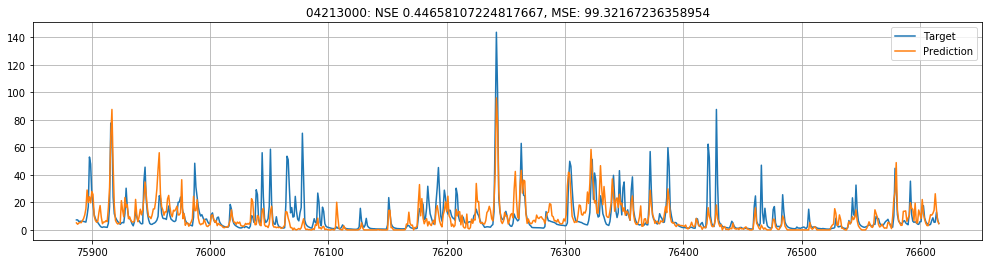

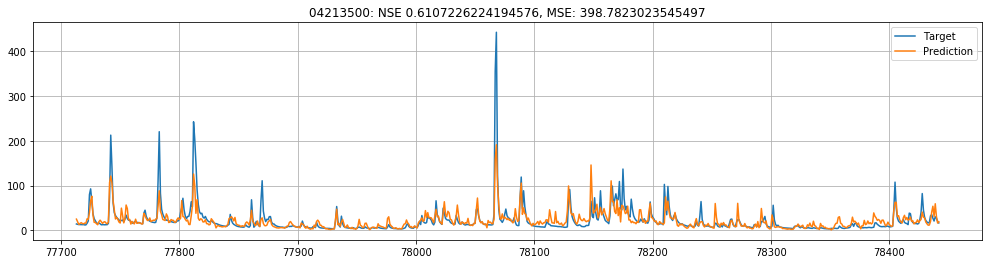

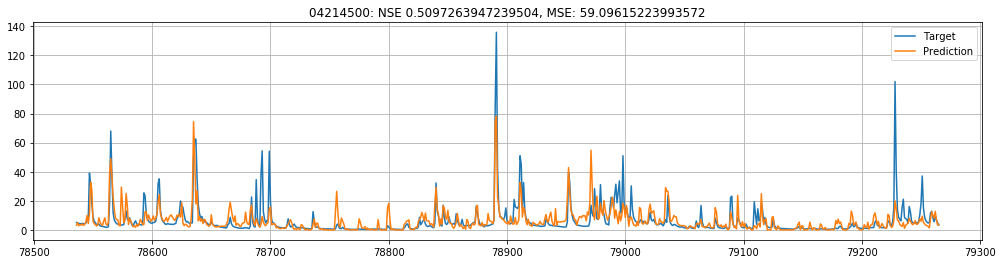

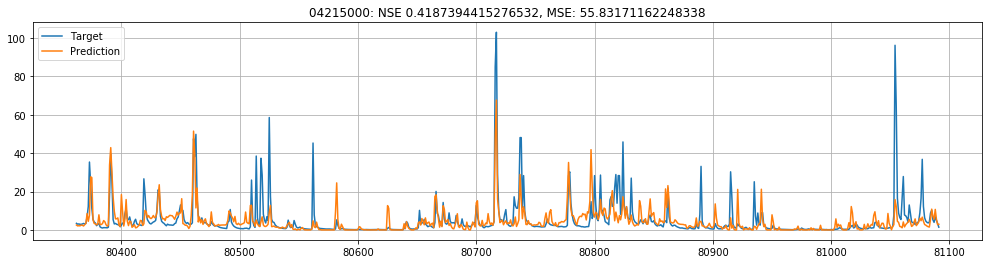

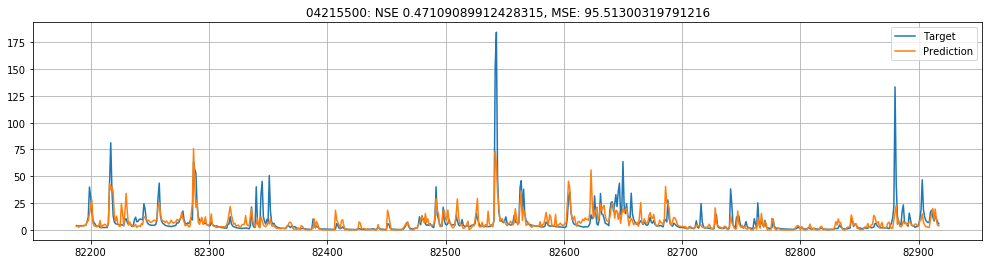

In [9]:
train_nse_list = []
train_mse_list = []
test_nse_list = []
test_mse_list = []
grouped_predict = predict.groupby('station')
for station in grouped_predict.groups.keys():
    station_predict = grouped_predict.get_group(station)
    nse, mse = evaluate.evaluate_daily(station, station_predict[['runoff']], station_predict['actual'], plot=True)
    if station in test_stations:
        test_nse_list.append(nse)
        test_mse_list.append(mse)
    else:
        train_nse_list.append(nse)
        train_mse_list.append(mse)
    
    print(station, '\tNSE:', nse, '\tMSE:', mse, '(clipped to 0)')

print('Train Median NSE (clipped to 0)', np.median(train_nse_list), '/ Min', np.min(train_nse_list), '/ Max', np.max(train_nse_list))
print('Train Median MSE (clipped to 0)', np.median(train_mse_list), '/ Min', np.min(train_mse_list), '/ Max', np.max(train_mse_list))
print('Test Median NSE (clipped to 0)', np.median(test_nse_list), '/ Min', np.min(test_nse_list), '/ Max', np.max(test_nse_list))
print('Test Median MSE (clipped to 0)', np.median(test_mse_list), '/ Min', np.min(test_mse_list), '/ Max', np.max(test_mse_list))

In [10]:
load_data.pickle_results('XGBoost_VIC_aggregateForcings_generalizationTest_withLandcover', predict[['date', 'station', 'runoff', 'actual', 'is_test_station']].rename({'runoff': 'prediction'}, axis=1).reset_index(drop=True), time_stamp)

'XGBoost_VIC_aggregateForcings_generalizationTest_withLandcover_20190728-093400.pkl'

In [11]:
load_data.pickle_model('XGBoost_VIC_aggregateForcings_generalizationTest_withLandcover', m, 'all', time_stamp, model_type='sklearn')

Saved model as ../pickle/models/XGBoost_VIC_aggregateForcings_generalizationTest_withLandcover_all_20190728-093400.pkl


In [12]:
datetime.now().strftime('%Y%m%d-%H%M%S')

'20190728-150153'